In [158]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import expm
import qutip as qt
import mpl_toolkits.mplot3d

In [138]:
class Hamiltonian:
    def __init__(self, rabi, detuning):
        self.rabi = rabi
        self.detuning = detuning
        
    def get_hamiltonian(self):
        hamiltonian = np.array([[self.detuning/2, self.rabi/2],[self.rabi/2, -self.detuning/2]])
        return hamiltonian

In [139]:
# Define the Hamiltonian with rabi=1 and detuning=0.5
h = Hamiltonian(rabi=1, detuning=0)

System = h.get_hamiltonian()

print(System)

expm(-1j*System*3)

[[0.  0.5]
 [0.5 0. ]]


array([[0.0707372+0.j        , 0.       -0.99749499j],
       [0.       -0.99749499j, 0.0707372+0.j        ]])

In [140]:
#
class Eigenstates:
    def __init__(self, hamiltonian):
        self.hamiltonian = hamiltonian
        
    def get_states(self):
        eigenvalues, eigenvectors = np.linalg.eig(self.hamiltonian.get_hamiltonian())
        self.eigenvectors = eigenvectors
        self.eigenvalues = eigenvalues
        
        return self.eigenvectors, eigenvalues

In [141]:
# Define the States class using the Hamiltonian
s = Eigenstates(h)

# Calculate the eigenvectors and eigenvalues
vectors, values = s.get_states()

print(np.array(vectors))

print(values)

print(np.linalg.inv(vectors))

np.array(vectors).dot(np.array([1, 0]))

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[ 0.5 -0.5]
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


array([0.70710678, 0.70710678])

In [142]:
class InitialState:
    def __init__(self, states):
        self.states = states
        
    def get_initial(self):
        states, _ = self.states.get_states()
        initial_state = np.array([1, 0])
        coefficients = np.linalg.inv(states).dot(initial_state)
        
        return coefficients, initial_state

In [143]:
# Calculate the initial state coefficients
initial_state = InitialState(s)

# calculate coefficients
coefficients, _ = initial_state.get_initial()

print(coefficients)

[ 0.70710678 -0.70710678]


In [144]:
class TimeEvolutionMatrix:
    def __init__(self, hamiltonian):
        self.hamiltonian = hamiltonian
    
    def get_matrix(self, t):
        time_evolution_matrix = expm(-1j * self.hamiltonian.get_hamiltonian() * t)
        return time_evolution_matrix

In [145]:
# Calculate the initial state coefficients
time_evolution_matrix = TimeEvolutionMatrix(h)

#calculate coefficients
matrix = time_evolution_matrix.get_matrix(0.5)

print(matrix)

[[0.96891242+0.j         0.        -0.24740396j]
 [0.        -0.24740396j 0.96891242+0.j        ]]


In [146]:
class State:
    def __init__(self, initial_state, time_evolution_matrix):
        self.initial_state = initial_state
        self.time_evolution_matrix = time_evolution_matrix
    
    def get_state(self, t):
        _, initial = self.initial_state.get_initial()
        evolved_state = np.dot(self.time_evolution_matrix.get_matrix(t), initial)
        return evolved_state
    
    def get_probability(self, t):
        excited_state = np.array([0, 1])
        probability = np.abs(np.dot(excited_state, self.get_state(t))) ** 2
        return probability

In [147]:
state = State(initial_state, time_evolution_matrix)

# Calculate the state at time t
t = 3.141592653/2
evolved_state = state.get_state(t)

# Calculate the probability of occupation of the higher state
probability = state.get_probability(t)

print("Evolved State:", evolved_state)
print("Probability:", probability)

Evolved State: [0.70710678+0.j         0.        -0.70710678j]
Probability: 0.4999999998525517


In [148]:
class ProbabilityPlotter:
    def __init__(self, state, time_points):
        self.state = state
        self.time_points = time_points
        
    def plot_probabilities(self):
        probabilities = [self.state.get_probability(t) for t in self.time_points]
        
        f = plt.figure()
        ax = f.add_subplot(211)
        ax.plot(self.time_points, probabilities, color='black')
        ax.set_xlabel('Programmed Delay (no. clock cycles)')
        ax.set_ylabel('Actual Delay (ns)')
        ax.legend(["FPGA Output Signal", "Input Signal"], loc=1, frameon=True)

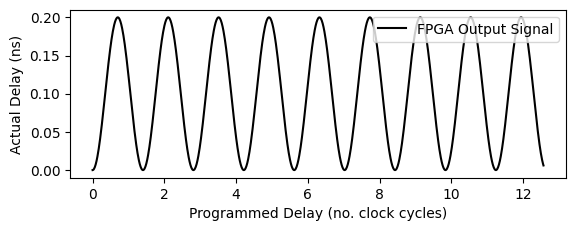

In [149]:
# Create instances of the required classes
hamiltonian = Hamiltonian(rabi=2, detuning=4)
time_evolution_matrix = TimeEvolutionMatrix(hamiltonian)
states = Eigenstates(hamiltonian)
initial_state = InitialState(states)  # Make sure to provide the appropriate `states` object
state = State(initial_state, time_evolution_matrix)

# Define the time points
time_points = np.linspace(0, 4*np.pi, 2**10)

# Create an instance of ProbabilityPlotter and plot the probabilities
plotter = ProbabilityPlotter(state, time_points)
plotter.plot_probabilities()

In [150]:
class ProbabilityPlotter3:
    def __init__(self, rabi_freq, time_points):
        self.rabi_freq = rabi_freq
        self.time_points = time_points
    
    def get_probabilities(self):
        hamiltonian1 = Hamiltonian(rabi=self.rabi_freq, detuning=0)
        hamiltonian2 = Hamiltonian(rabi=self.rabi_freq, detuning=self.rabi_freq)
        hamiltonian3 = Hamiltonian(rabi=self.rabi_freq, detuning=2*self.rabi_freq)
        time_evolution_matrix1 = TimeEvolutionMatrix(hamiltonian1)
        time_evolution_matrix2 = TimeEvolutionMatrix(hamiltonian2)
        time_evolution_matrix3 = TimeEvolutionMatrix(hamiltonian3)
        state1 = State(InitialState(Eigenstates(hamiltonian1)), time_evolution_matrix1)
        state2 = State(InitialState(Eigenstates(hamiltonian2)), time_evolution_matrix2)
        state3 = State(InitialState(Eigenstates(hamiltonian3)), time_evolution_matrix3)
        probabilities1 = [state1.get_probability(t) for t in self.time_points]
        probabilities2 = [state2.get_probability(t) for t in self.time_points]
        probabilities3 = [state3.get_probability(t) for t in self.time_points]
        return probabilities1, probabilities2, probabilities3
        
    def plot_probabilities(self):
        probabilities1, probabilities2, probabilities3 = ProbabilityPlotter3(self.rabi_freq, self.time_points).get_probabilities()

        f = plt.figure()
        ax = f.add_subplot(111)
        ax.plot(self.time_points, probabilities1, color='red')
        ax.plot(self.time_points, probabilities2, color='blue')
        ax.plot(self.time_points, probabilities3, color='green')
        ax.set_xlabel('Excited State Probability')
        ax.set_ylabel('Excited State Probability vs. Time')
        ax.legend(["detuning = 0", "detuning = rabi frequency", "detuning = 2 x rabi frequency"], loc=1, frameon=True)
        plt.savefig('Rabi3.pdf',bbox_inches='tight')

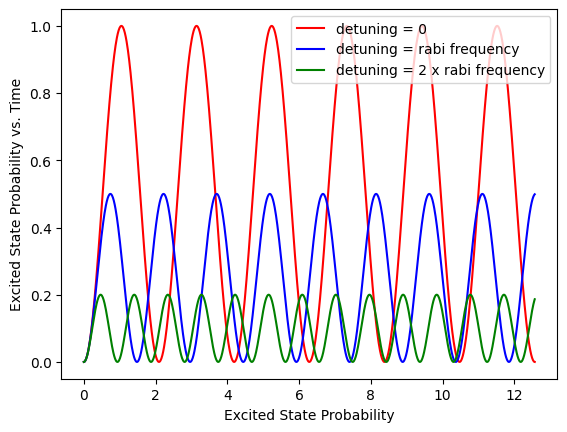

In [151]:
rabi_freq = 3
time_points = np.linspace(0, 4*np.pi, 2**10)

plotter = ProbabilityPlotter3(rabi_freq, time_points)
plotter.plot_probabilities()

In [152]:
class DensityMatrix:
    def __init__(self, state):
        self.state = state
    
    def get_density_matrix(self, t):
        evolved_state = self.state.get_state(t)
        density_matrix = np.outer(evolved_state, np.conj(evolved_state))
        return density_matrix

In [153]:
state = State(initial_state, time_evolution_matrix)
density_matrix_calculator = DensityMatrix(state)

# Set the time point at which you want to calculate the density matrix
t = 2.0

# Obtain the density matrix
density_matrix = density_matrix_calculator.get_density_matrix(t)

print("Density Matrix:")
print(density_matrix)

Density Matrix:
[[0.81132389+0.j         0.37735223+0.10335732j]
 [0.37735223-0.10335732j 0.18867611+0.j        ]]


NameError: name 'Arrow3D' is not defined

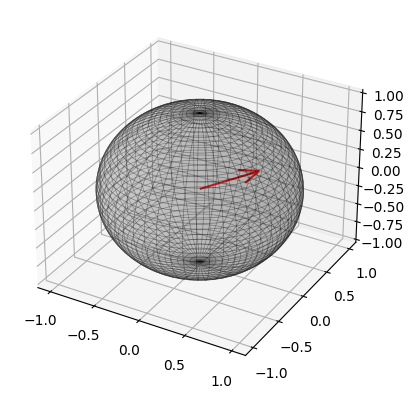

In [159]:
class BlochSpherePlotter:
    def __init__(self, density_matrix):
        self.density_matrix = density_matrix
    
    def bloch_vector(self):
        qobj = qt.Qobj(self.density_matrix)
        bloch_vector = np.array([np.real(np.trace(qobj * qt.sigmax())), np.real(np.trace(qobj * qt.sigmay())), np.real(np.trace(qobj * qt.sigmaz()))])
        norm = np.linalg.norm(bloch_vector)
        return bloch_vector, norm
        
    
    def plot_bloch_sphere(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot Bloch sphere
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_surface(x, y, z, color='gray', alpha=0.2, edgecolor='k', linewidth=0.5)
        
        # Plot vector
        vector, norm = BlochSpherePlotter(self.density_matrix).bloch_vector()
        ax.quiver(0, 0, 0, vector[0], vector[1], vector[2], color='r')
        
        phi = np.arctan2(vector[1], vector[0])
        theta = np.arccos(vector[2]/norm)
        
        # Plot arrow from origin to vector
        arrow = Arrow3D([0, vector[0]], [0, vector[1]], [0, vector[2]], mutation_scale=10, lw=1, arrowstyle="-|>", color='r')
        ax.add_artist(arrow)
        
        # Add labels for angles
        ax.text(vector[0], vector[1], vector[2], r"$|\psi\rangle$", fontsize=12, ha='center', va='center')
        ax.text(0, 0, 0, r"$\theta$", (np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)), fontsize=12, ha='center', va='center')
        ax.text(0, 0, 0, r"$\phi$", (np.cos(phi), np.sin(phi), 0), fontsize=12, ha='center', va='center')
        
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        plt.show()

# Example usage
bloch_plotter = BlochSpherePlotter(density_matrix)
bloch_plotter.plot_bloch_sphere()
print(bloch_plotter.bloch_vector())